In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import numpy as np
import bidi.algorithm
import arabic_reshaper
import adhtools.utils

In [2]:
fpath = '/media/sf_VBox_Shared/Arabic/Analyses/topicmodelling/'

In [25]:
document_topics = pd.read_csv(os.path.join(fpath, 'document_topics_10.csv'), index_col=0).sort_index()
df_topics = pd.read_csv(os.path.join(fpath, 'topics_10.csv'), index_col=0)
metadata = pd.read_csv(os.path.join(fpath, 'metadata.csv'), index_col=0)

In [37]:
metadata.to_csv(os.path.join(fpath, 'metadata.csv'))

In [29]:
metadata = metadata.set_index('filename')

In [4]:
topic_names = df_topics['0'] +' '+ df_topics['1'] +' '+ df_topics['3']

In [17]:
import glob
book_files = glob.glob('/media/sf_VBox_Shared/Arabic/Fiqh/2018-11-13-Fiqh-stemmed-chapters/*.xml')
c = adhtools.utils.corpus_wordlist(book_files, analyzer=False, field='proposed_root')
chapter_lengths = {os.path.basename(b): len(l) for (b,l) in zip (book_files, c)}
metadata['ChapterLength'] = pd.Series(chapter_lengths)

In [38]:
def split_fname(fname):
    splitted = fname.split('-')
    bookname = splitted[0]
    if len(splitted)>1:
        chapter = int(splitted[-1].split('.')[0])
    else:
        chapter = 0
    return (bookname, chapter)
fnames = document_topics.index
ind = pd.MultiIndex.from_tuples(document_topics.index.map(split_fname))
document_topics = document_topics.set_index(ind)
fnames_s = pd.Series(fnames, index=ind)

In [39]:
document_topics.head()

0         1         2         3         4  \
0179MalikIbnAnas.Muwatta 0  0.612438  0.000265  0.000265  0.000265  0.000265   
                         1  0.854471  0.001961  0.001962  0.001961  0.001961   
                         2  0.452199  0.001818  0.001818  0.001818  0.001819   
                         3  0.543650  0.000746  0.000746  0.000746  0.000747   
                         4  0.879009  0.000369  0.000369  0.000369  0.000369   

                                   5         6         7         8         9  
0179MalikIbnAnas.Muwatta 0  0.000265  0.000265  0.385445  0.000265  0.000265  
                         1  0.001962  0.001961  0.129838  0.001961  0.001961  
                         2  0.001818  0.001819  0.533253  0.001818  0.001818  
                         3  0.000746  0.000746  0.450378  0.000746  0.000747  
                         4  0.029043  0.000369  0.089364  0.000369  0.000369

In [44]:
fnames_s.name = 'filename'

In [48]:
metadata_newind = metadata.join(fnames_s.reset_index().set_index('filename')).set_index(['level_0', 'level_1'])

In [7]:
new_ind = []
book_names = sorted(ind.levels[0])
for book in book_names:
    new_ind.extend(list(range(len(document_topics.loc[book]))))
new_ind = pd.MultiIndex.from_tuples(zip(ind.get_level_values(0), new_ind))

In [120]:
largest_topics = document_topics.idxmax(axis=1)
largest_topics = pd.concat([largest_topics,  metadata_newind['ChapterLength'], metadata_newind['Number_of_tokens']], axis=1)
#largest_topics.index = new_ind
largest_topics = largest_topics.reset_index()
largest_topics.columns = ['book', 'chapter', 'topic', 'length', 'total_length']
book_dict = {b: i for i,b in enumerate(book_names)}

In [189]:
metadata_newind['topic'] = largest_topics.set_index(['book', 'chapter'])['topic']
metadata_newind['topic_name'] = [topic_names[int(topic)] for topic in metadata_newind['topic']]

In [192]:
metadata_newind.to_csv(os.path.join(fpath, 'chapters_metadata_topics.csv'))

In [121]:
largest_topics['x1'] = largest_topics.groupby('book')['length'].transform(pd.Series.cumsum)
largest_topics['x0'] = largest_topics['x1'] - largest_topics['length']

In [122]:
largest_topics['total_length'] = largest_topics.groupby('book')['x1'].transform(lambda l: [l.max()]*len(l))

In [123]:
largest_topics['perc0'] = largest_topics['x0'] / largest_topics['total_length']
largest_topics['perc1'] = largest_topics['x1'] / largest_topics['total_length']

In [124]:
largest_topics[650:660]

,book,chapter,topic,length,total_length,x1,x0,perc0,perc1
650,0179MalikIbnAnas.Muwatta,650,0,171,140946,140758,140587,0.997453,0.998666
651,0179MalikIbnAnas.Muwatta,651,0,33,140946,140791,140758,0.998666,0.998900
652,0179MalikIbnAnas.Muwatta,652,0,118,140946,140909,140791,0.998900,0.999737
653,0179MalikIbnAnas.Muwatta,653,0,37,140946,140946,140909,0.999737,1.000000
654,0182AbuYusufYacqub.Kharaj.xml,0,0,67701,67701,67701,0,0.000000,1.000000
655,0264IbnYahyaMuzani.Mukhtasar,0,7,170,175122,170,0,0.000000,0.000971
656,0264IbnYahyaMuzani.Mukhtasar,1,7,161,175122,331,170,0.000971,0.001890
657,0264IbnYahyaMuzani.Mukhtasar,2,7,48,175122,379,331,0.001890,0.002164
658,0264IbnYahyaMuzani.Mukhtasar,3,7,79,175122,458,379,0.002164,0.002615
659,0264IbnYahyaMuzani.Mukhtasar,4,7,672,175122,1130,458,0.002615,0.006453


In [65]:
color_list = sns.color_palette(n_colors=len(topic_names))

In [66]:
import matplotlib.colors

def style_row(row):
    topic_id = int(row.name)
    color = matplotlib.colors.to_hex(color_list[topic_id])
    attr = 'background-color: {}'.format(color)
    return [attr for v in  row]
df_topics.style.apply(style_row, axis=1)

,0,1,2,3,4,5,6,7,8,9
0,قطع,قوم,يود,ثبت,حقق,حكم,قضي,قرر,دعا,شهد
1,عبر,علم,ذكر,خبر,خلف,عرف,ظهر,غور,سلم,عدم
2,خلف,غور,طهر,قوم,سلم,أمم,ركع,غسل,سجد,صلي
3,شرط,قوم,عقد,ملك,ثمن,رهن,قبض,جوز,شري,بيع
4,قوم,نصف,ولد,كتب,موت,قسم,وصي,عتق,أبن,ثلث
5,فلي,جور,قوم,زكي,جوز,أخذ,مول,عمل,أجر,ملك
6,ملك,دخل,ولد,مرأ,ثلث,وطأ,فلي,نكح,زوج,طلق
7,غور,وجب,حلل,جزأ,كفر,حوج,يوم,أكل,صوم,حرم
8,وبأ,فلي,صحي,الخ,خلف,شرح,ظهر,ذكر,غور,اه
9,روي,عمر,نبأ,حمد,فى,رسل,أبن,صلي,حدث,سلم


In [174]:
def plot_bar_per_book(largest_topics, xmin_col, xmax_col, book_names, topic_names, legend=True):
    book_dict = {b: i for i,b in enumerate(book_names)}

    plt.figure(figsize=(25, np.floor(len(book_names)*0.5)))
    ax = plt.gca()
    for topic in range(len(topic_names)):
        topic_name = topic_names[topic]
        largest_topics_sub = largest_topics[largest_topics['topic']==str(topic)]
        color = color_list[topic] 


        y = [book_dict[s] for s in largest_topics_sub['book']]
        #x = largest_topics_sub['chapter']
        xmin = largest_topics_sub[xmin_col]
        xmax = largest_topics_sub[xmax_col]
        ax.hlines(y, xmin, xmax, #marker='s', edgecolors=None, 
                  colors=np.array((color,)), lw=10,
                   label=bidi.algorithm.get_display(arabic_reshaper.reshape(topic_name)))
    ax.set_yticks(np.arange(len(book_dict)))
    ax.set_yticklabels(book_names)
    ax.set_xlim(0, largest_topics[xmax_col].max())
    ax.set_ylim(-0.5, len(book_names))
    if legend:
        plt.legend(fontsize='large')
    ax.invert_yaxis()
    plt.show()

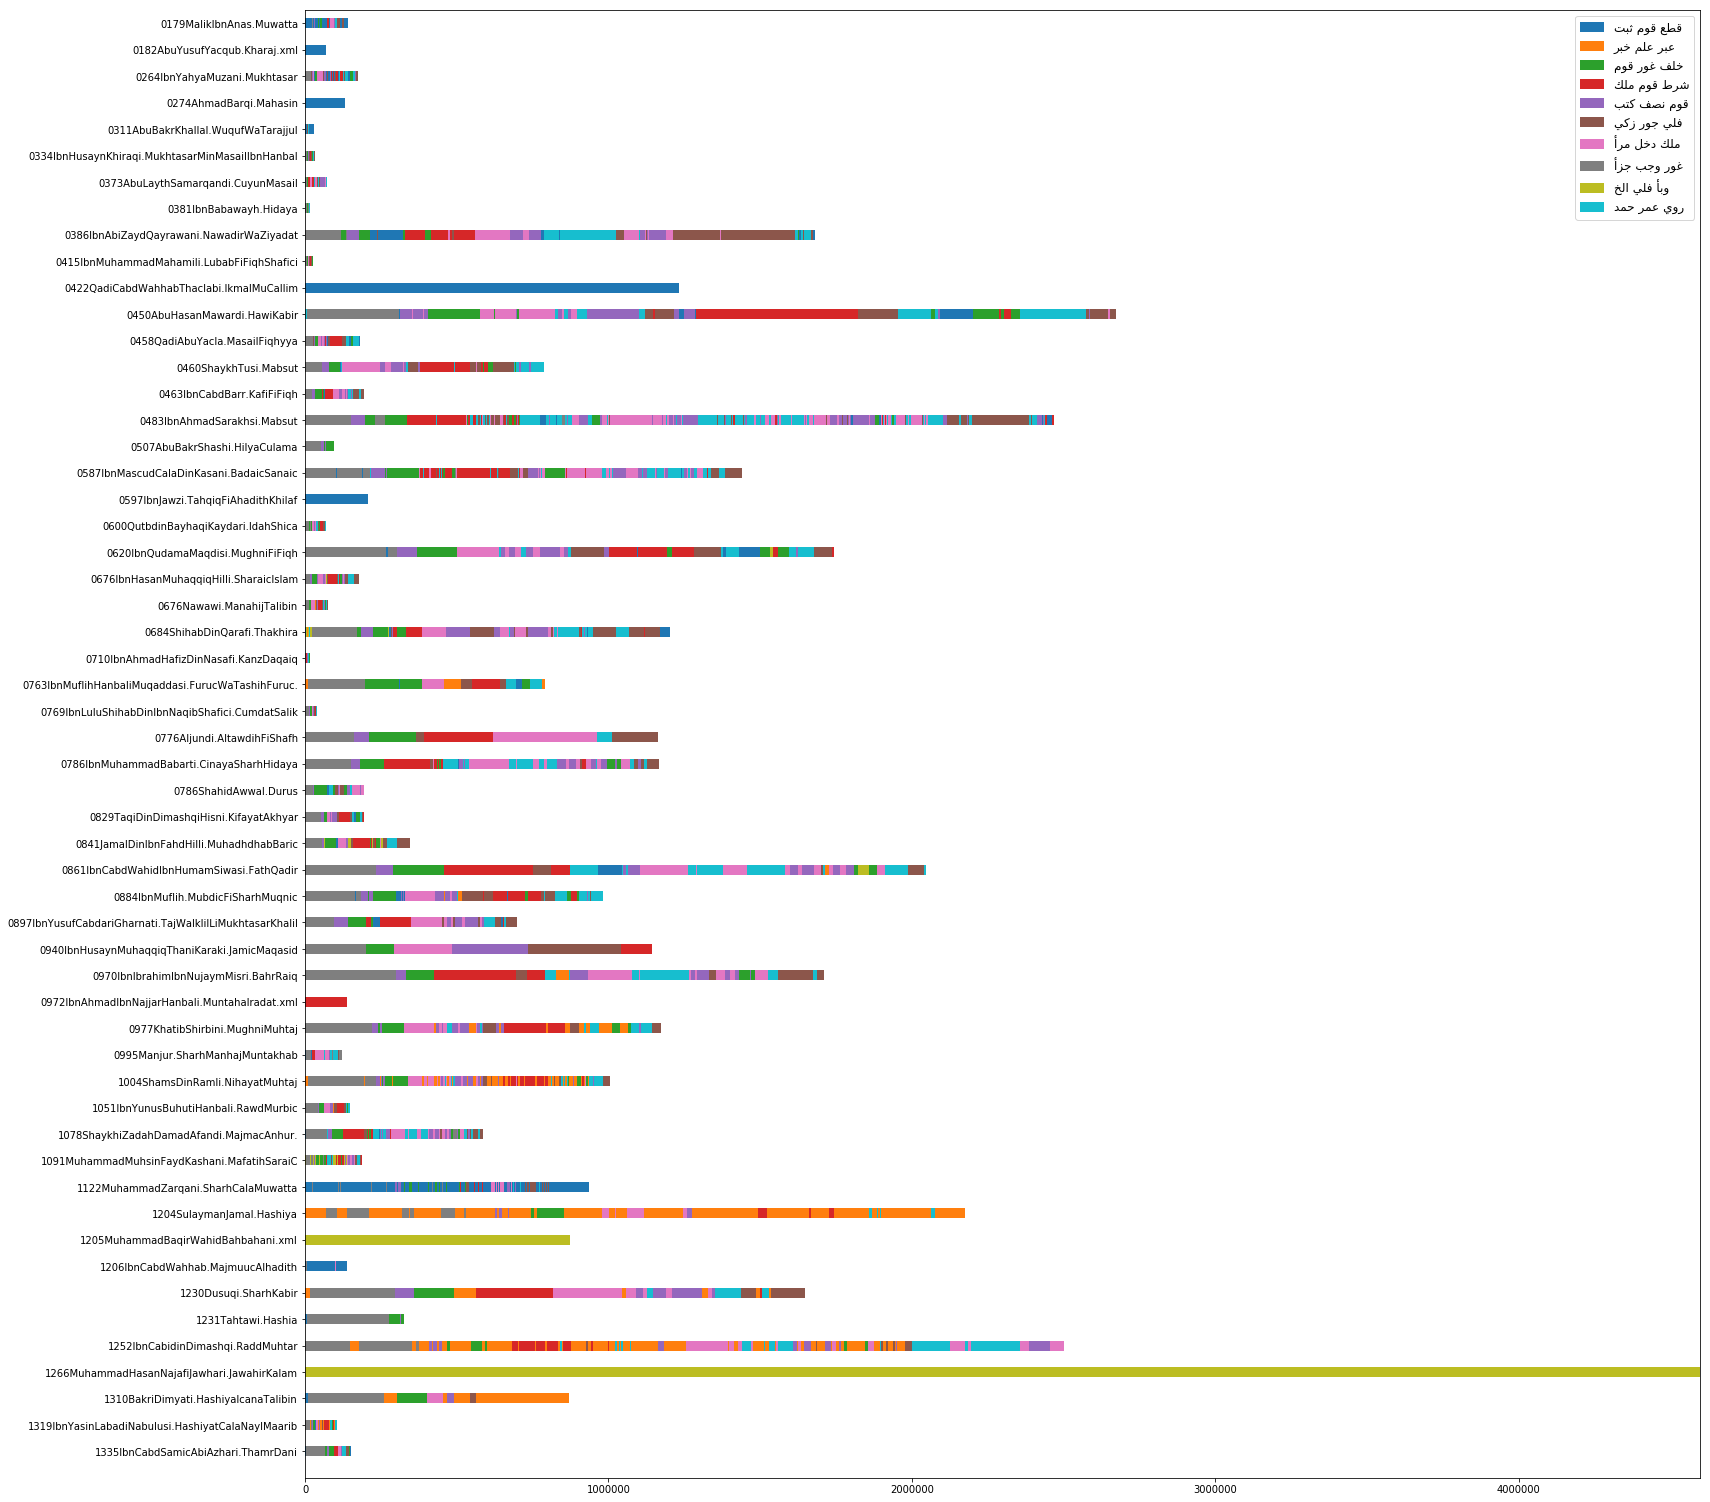

In [175]:
plot_bar_per_book(largest_topics, 'x0', 'x1', book_names, topic_names, legend=True)

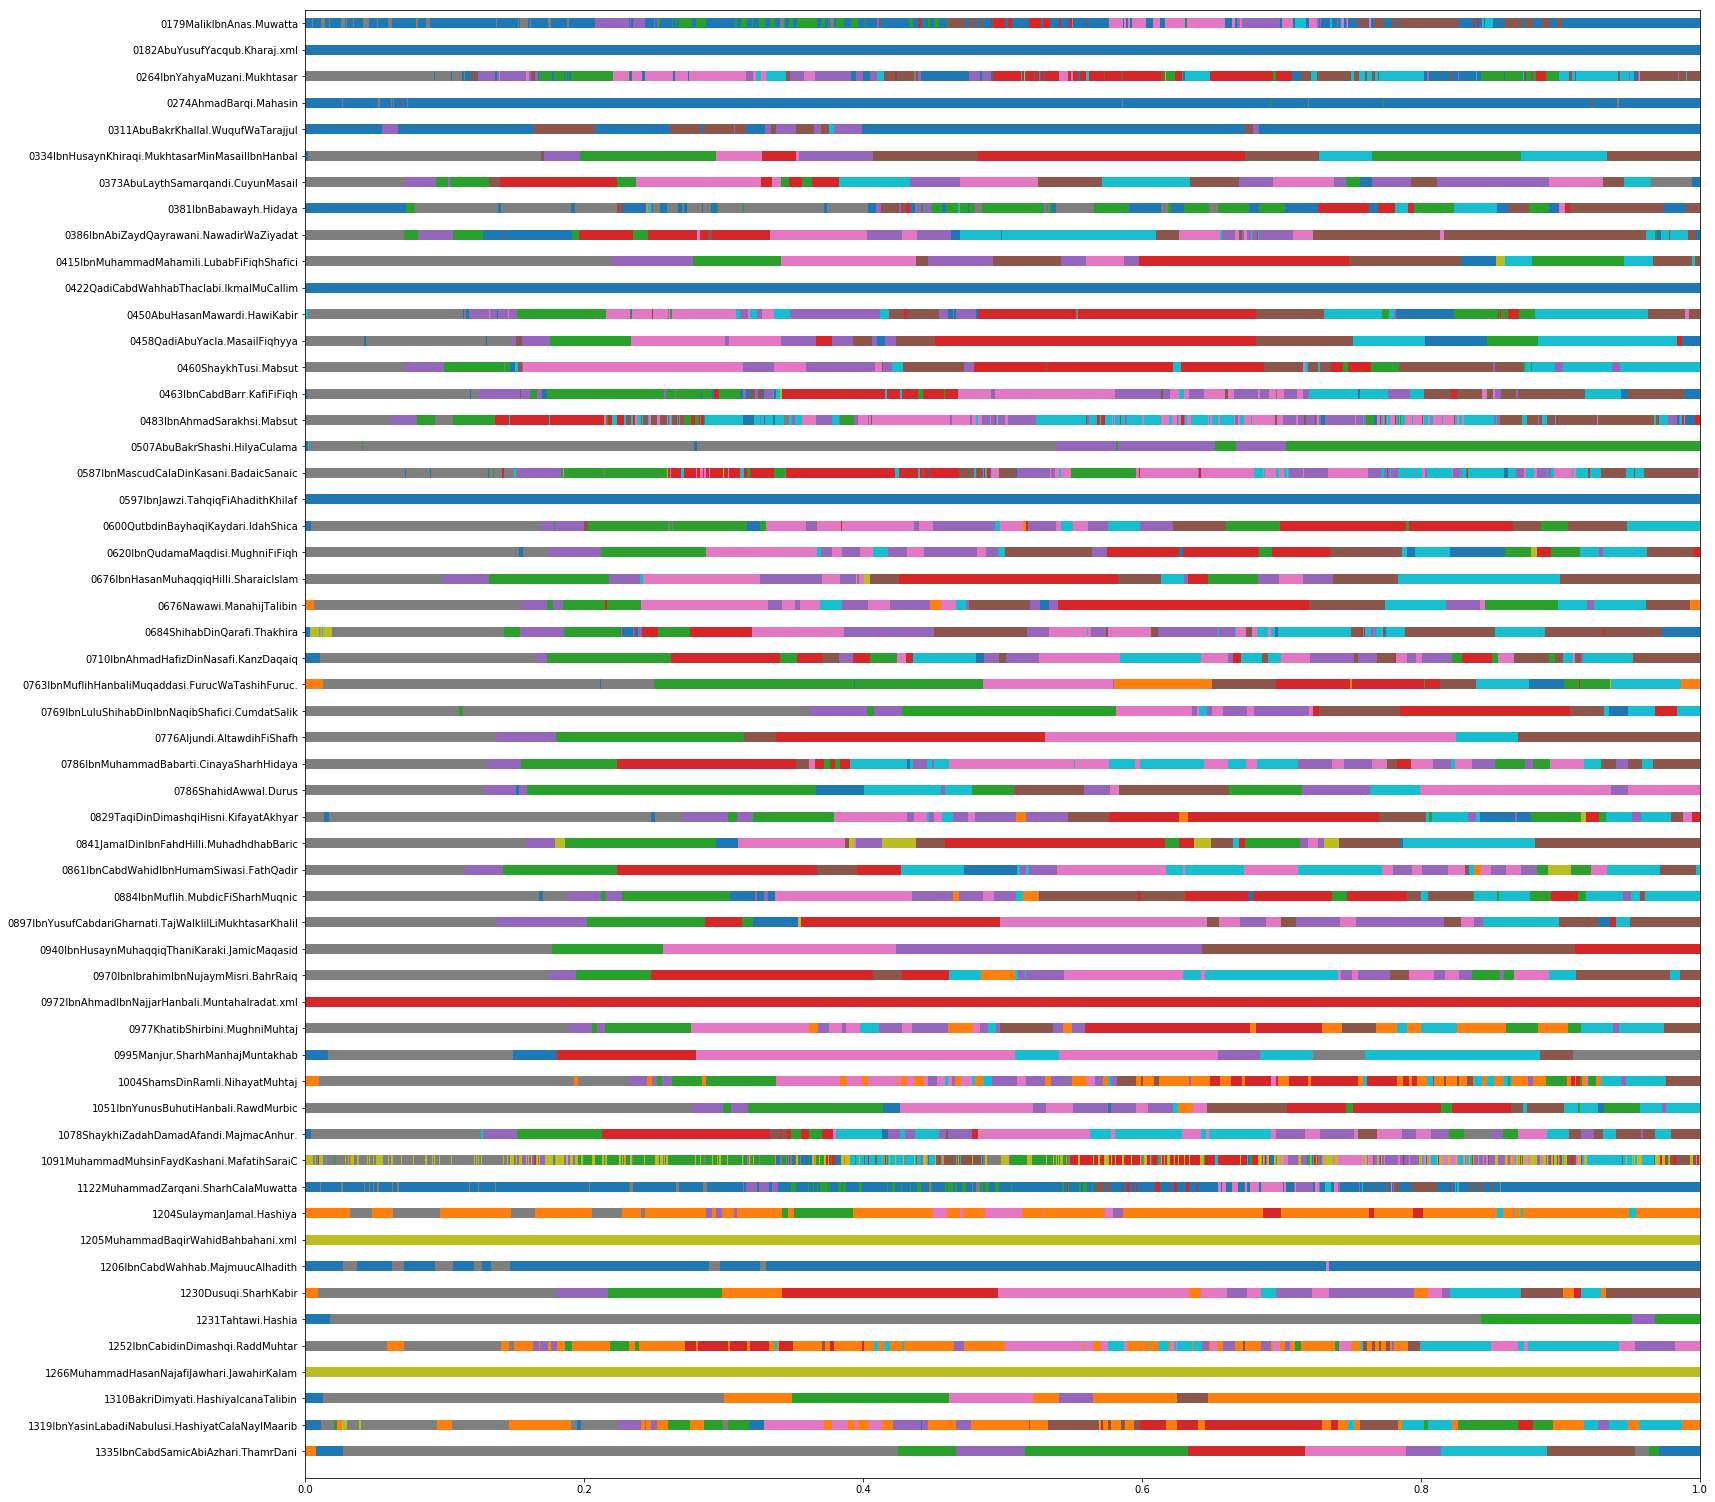

In [176]:
plot_bar_per_book(largest_topics, 'perc0', 'perc1', book_names, topic_names, legend=False)

مالكي


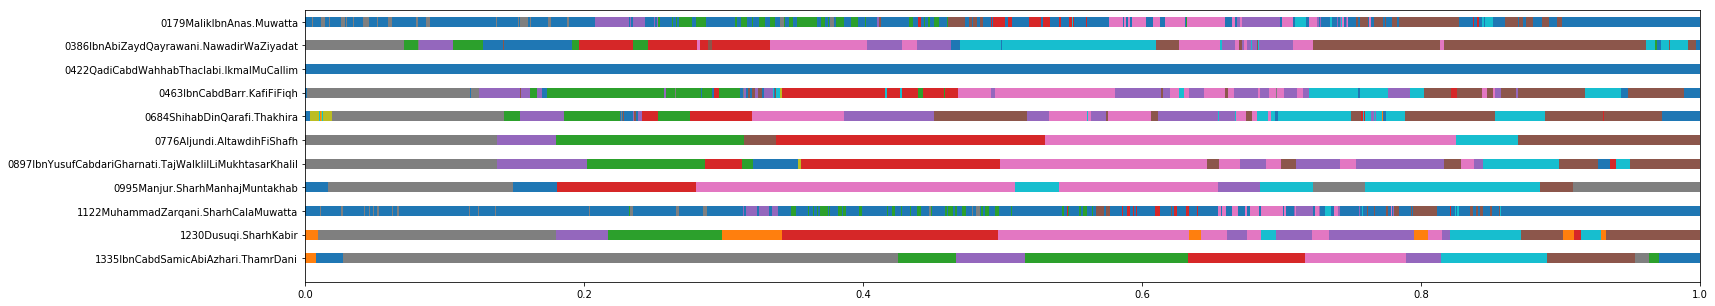

حنفي


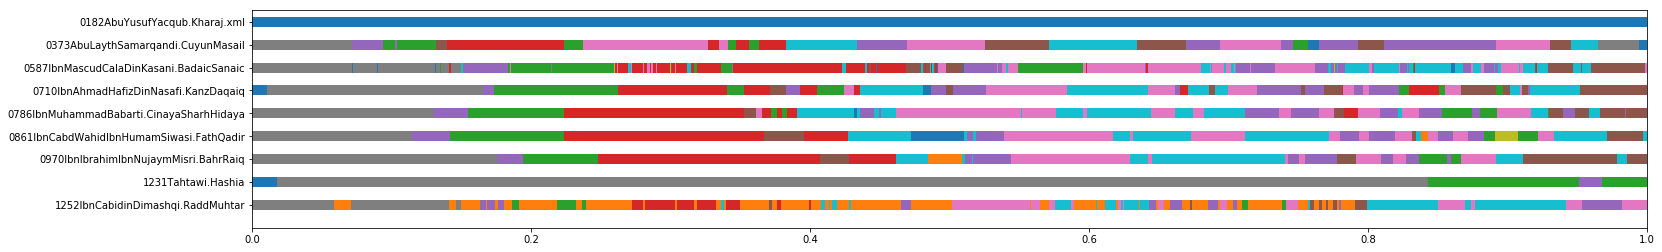

شافعي


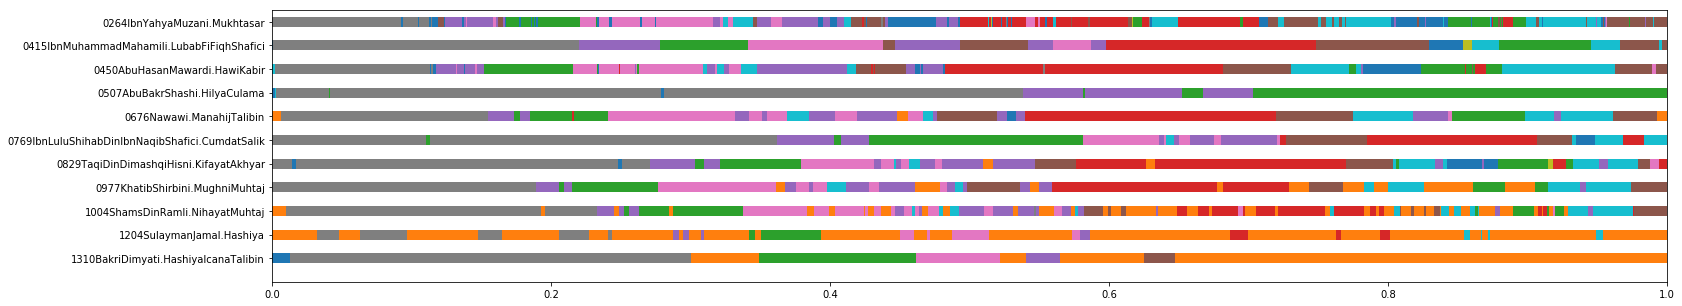

شيعي


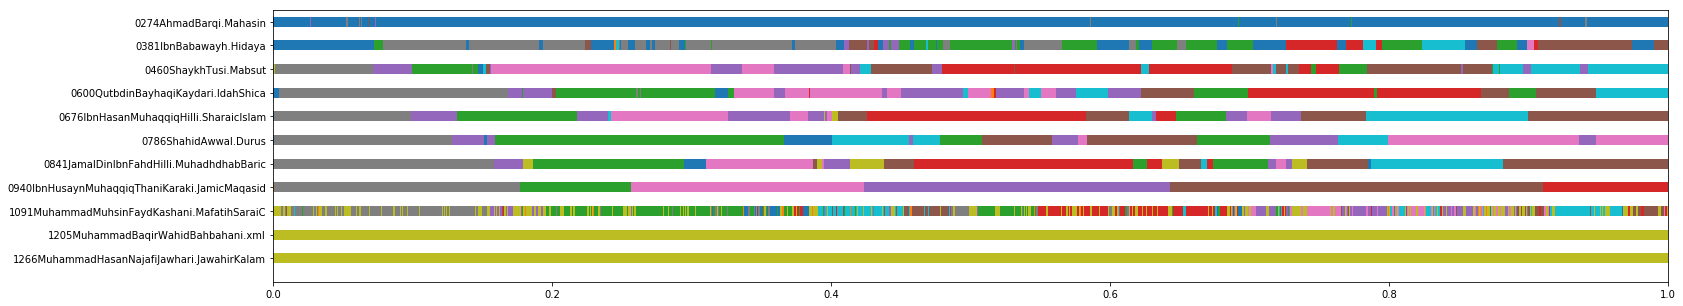

حنبلي


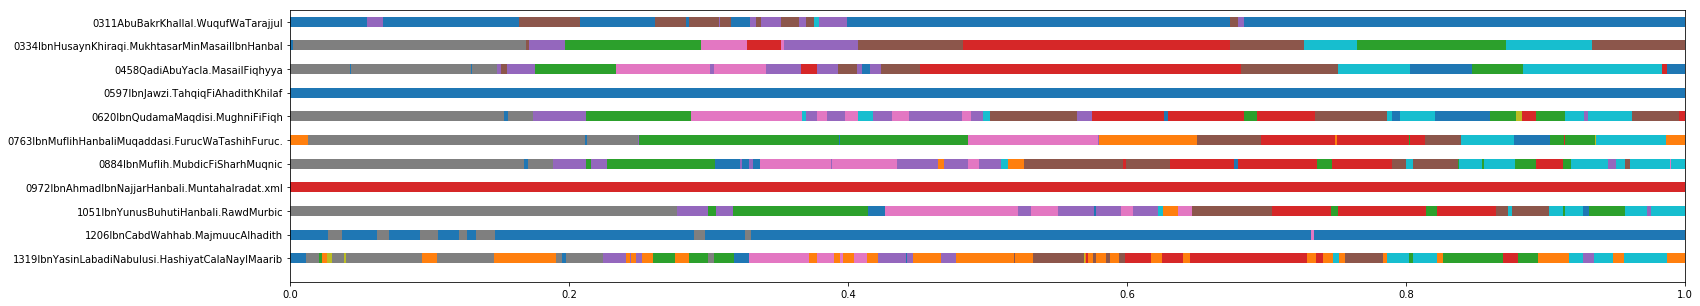

In [177]:
for subj in metadata.BookSUBJ.unique():
    if type(subj)==str:
        print(subj)
        ind_sub = metadata_newind[metadata_newind.BookSUBJ==subj].index.to_frame()
        ind_sub.columns = ['book', 'chapter']
        largest_topics_sub = largest_topics.merge(ind_sub, how='inner')
        plot_bar_per_book(largest_topics_sub, 'perc0', 'perc1', largest_topics_sub.book.unique(), topic_names, legend=False)

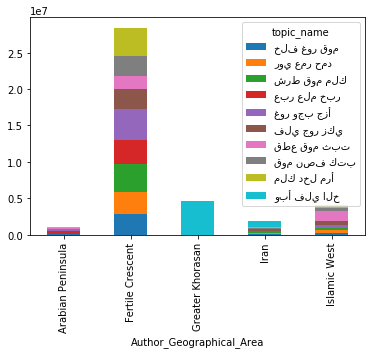

In [190]:
metadata_newind.groupby(['Author_Geographical_Area', 'topic_name'])['ChapterLength'].sum().unstack().plot(kind='bar', stacked=True)

In [272]:
def plot_bars_per_topic(df, topic_names, col1, col2='ChapterLength', aggfunc=sum, reshape_col1=False):
    plt.figure(figsize=(15,10))
    ax = plt.gca()
    values = df.groupby([col1, 'topic'])[col2].apply(aggfunc).sort_values()
    values = values.unstack().fillna(0)
    sorted_index = values.sum(axis=1).sort_values(ascending=False).index
    values = values.loc[sorted_index,:]
    ind0 = values.index
    ind1 = values.columns
    x = np.arange(len(ind0))
    last_y = np.repeat(0, len(ind0))
    for t in ind1:
        y = values[t]
        ax.bar(x, y, bottom=last_y, color=color_list[int(t)],
                label=bidi.algorithm.get_display(arabic_reshaper.reshape(topic_names[int(t)])))
        last_y = last_y+y
    if reshape_col1:
        xlabels = [bidi.algorithm.get_display(arabic_reshaper.reshape(l)) for l in ind0]
    else:
        xlabels = ind0
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=90)
    plt.legend()
    plt.show()

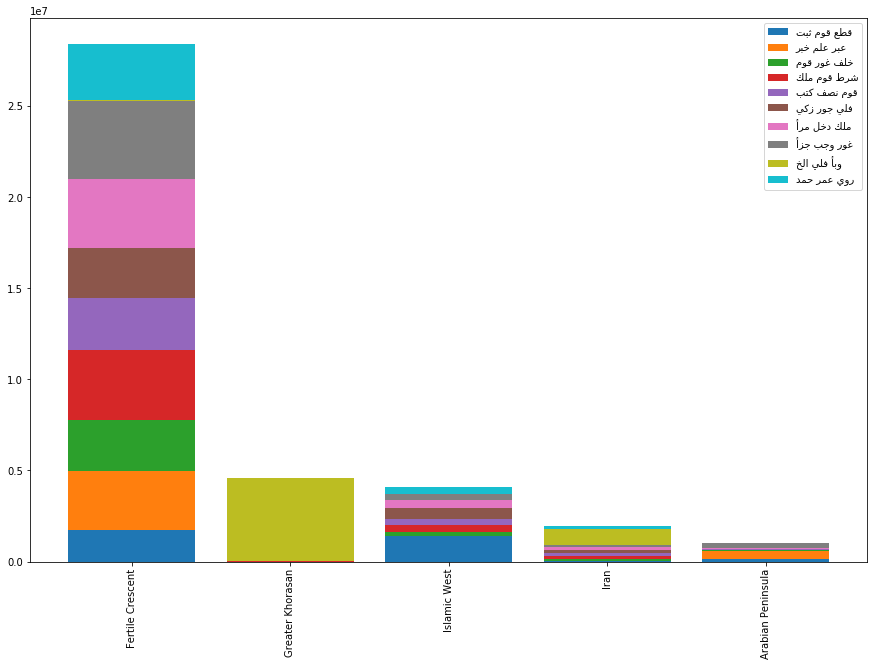

In [273]:
plot_bars_per_topic(metadata_newind, topic_names, 'Author_Geographical_Area')

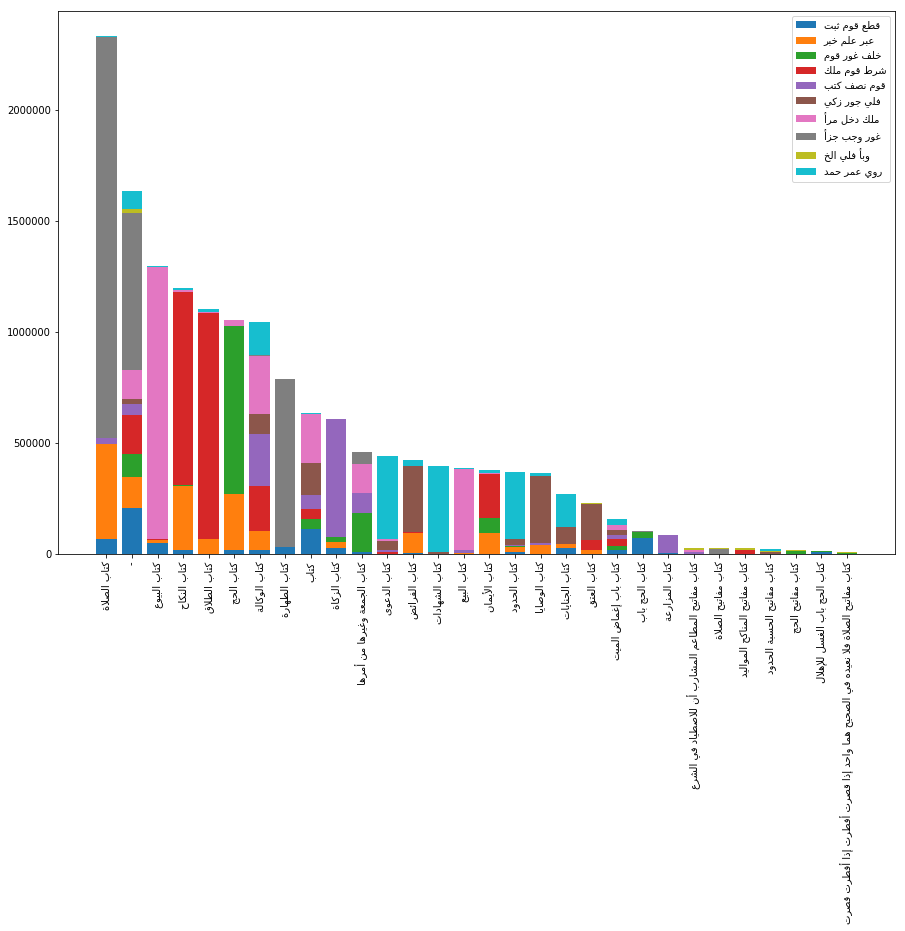

In [275]:
# The 30 most common volume names
voltitles = metadata_newind['VolumeTitle'].value_counts().head(30).index
meta_sub = metadata_newind[metadata_newind.VolumeTitle.isin(voltitles)]
plot_bars_per_topic(meta_sub, topic_names, 'VolumeTitle', reshape_col1=True)

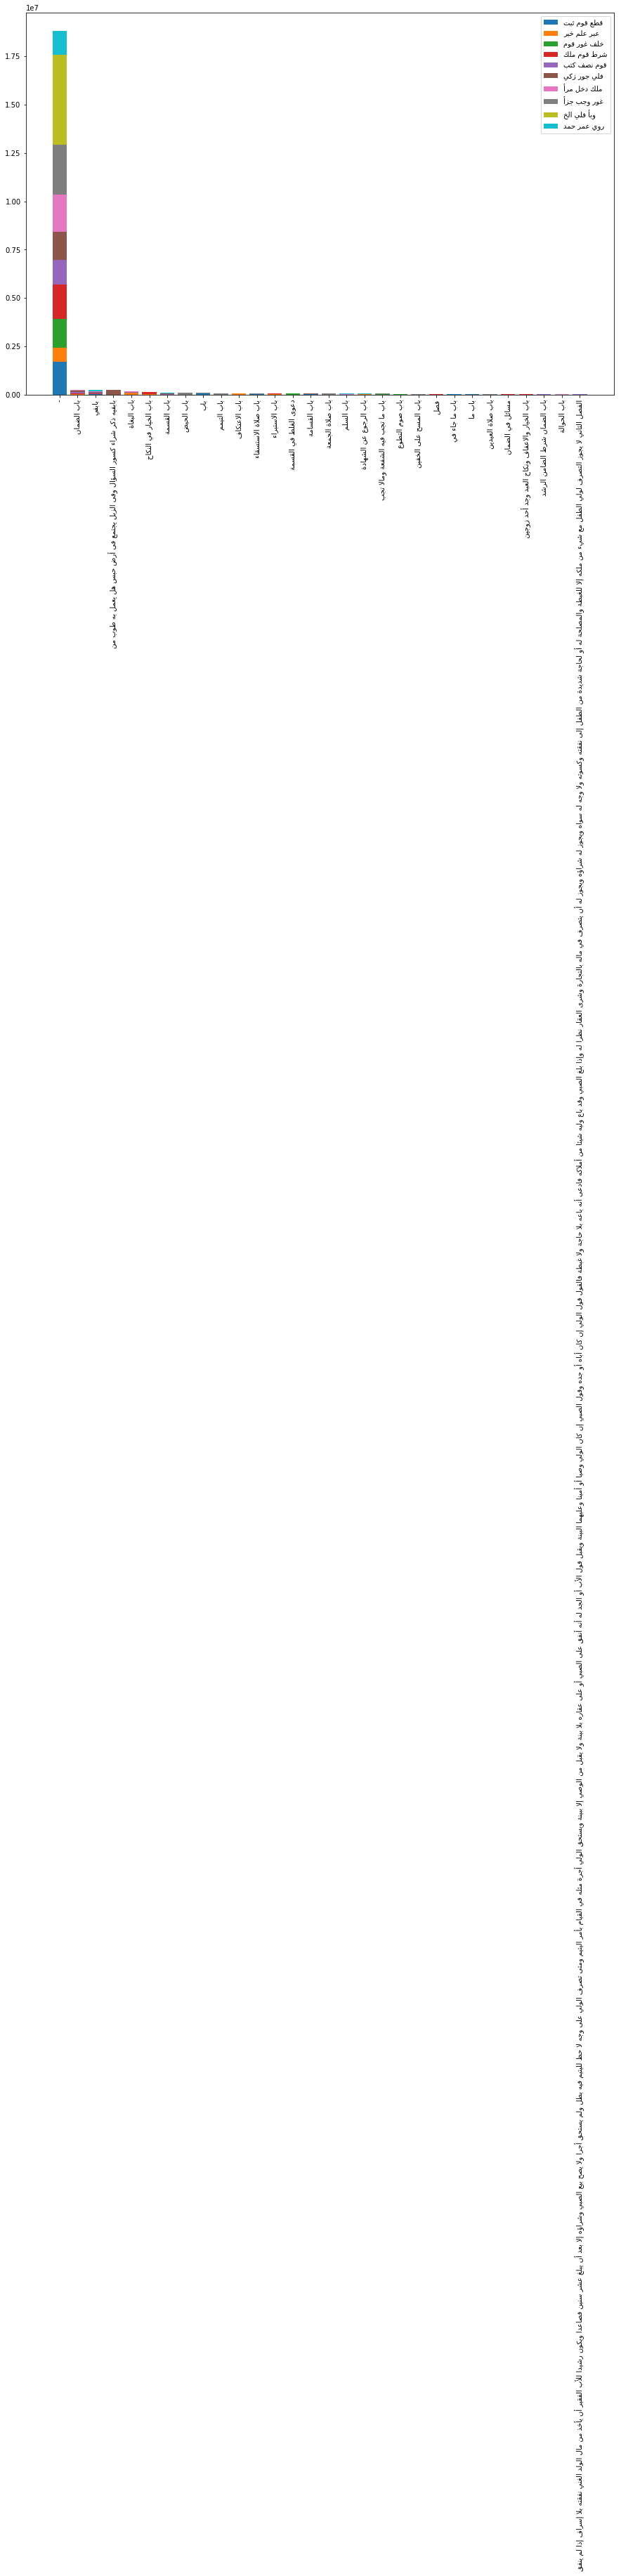

In [276]:
# The 30 most common chapter names
voltitles = metadata_newind['ChapterTitle'].value_counts().head(30).index
meta_sub = metadata_newind[metadata_newind.ChapterTitle.isin(voltitles)]
plot_bars_per_topic(meta_sub, topic_names, 'ChapterTitle', reshape_col1=True)